<h1>Содержание<span class="tocSkip"></span></h1>
</a></span><li><span><a  href="#Изучение данных из файла" data-toc-modified-id="Изучение данных из файла"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение данных из файла</a></span><li><span><a href="#Приоритизация гипотез" data-toc-modified-id="Приоритизация гипотез-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Приоритизация гипотез</a></span></li><li><span><a href="#Анализ A/B-теста" data-toc-modified-id="Анализ A/B-теста"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ A/B-теста</a></span></li><li><span><a href="#Анализ A/B-теста" data-toc-modified-id="Итоговые выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Итоговые выводы</a>

# Принятие решений в бизнесе. Приоритезация гипотез. A/B тест.

Проводится анализ крупного интернет-магазина. Вместе с отделом маркетинга подготовлен список гипотез для увеличения выручки.
Приоритизируем гипотезы, необходимо запустить A/B-тест и проанализировать результаты. Для анализа также необходимо постороить график кумулятивной выручки по группам и график кумулятивного среднего чека по группам, выявить аномальные заказы. Принять решение по результат теста.

## Изучение данных из файла

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import datetime as dt

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv') # прочитала файл /datasets/hypothesis.csv и сохранила его в переменной hypothesis
display(hypothesis.head(10)) # вывела на экран первые пятнадцать строк таблицы
hypothesis.info() # получила общую информацию о таблице

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


В таблице 9 строк, пропусков не выявлено, предобработка не требуется.

# Описание данных таблицы hypothesis

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [3]:
orders = pd.read_csv('/datasets/orders.csv') # прочитала файл /datasets/orders.csv и сохранила его в переменной orders
display(orders.head(10)) # вывела на экран первые пятнадцать строк таблицы
orders.info() # получила общую информацию о таблице

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


# Описание данных таблицы orders

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

In [4]:
orders['date'] = orders['date'].astype('datetime64[D]')
orders['date'] = orders['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
print('\nНачальная дата {}, конечная дата {}\n'.format(orders['date'].min(), orders['date'].max()))
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))


Начальная дата 2019-08-01, конечная дата 2019-08-31



In [5]:
orders.duplicated().sum()

0

В таблицк 1197 строк, пропусков и дубликатов не выявлено, формат даты приведен к верному значению.

In [6]:
visitors = pd.read_csv('/datasets/visitors.csv') # прочитала файл /datasets/visitors.csv и сохранила его в переменной visitors
display(visitors.head(10)) # вывела на экран первые пятнадцать строк таблицы
visitors.info() # получила общую информацию о таблице

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


# Описание данных таблицы orders

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [7]:
visitors['date'] = visitors['date'].astype('datetime64[D]')
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
print('\nНачальная дата {}, конечная дата {}\n'.format(visitors['date'].min(), visitors['date'].max()))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))


Начальная дата 2019-08-01, конечная дата 2019-08-31



In [8]:
visitors.duplicated().sum()

0

В таблице 62 строки, пропусков и дубликатов не выявлено, формат даты приведен к верному значению, выгрузка верная, даты совпадают.

## Приоритизация гипотез

# Приоритезация гипотез методом ICE

In [9]:
display(hypothesis.head(5))

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [10]:
hypothesis['ICE'] = hypothesis['Impact']*hypothesis['Confidence']/hypothesis['Efforts']

print(hypothesis[['Hypothesis','ICE']].sort_values(by='ICE', ascending=False))

                                          Hypothesis        ICE
8  Запустить акцию, дающую скидку на товар в день...  16.200000
0  Добавить два новых канала привлечения трафика,...  13.333333
7  Добавить форму подписки на все основные страни...  11.200000
6  Показать на главной странице баннеры с актуаль...   8.000000
2  Добавить блоки рекомендаций товаров на сайт ин...   7.000000
1  Запустить собственную службу доставки, что сок...   2.000000
5  Добавить страницу отзывов клиентов о магазине,...   1.333333
3  Изменить структура категорий, что увеличит кон...   1.125000
4  Изменить цвет фона главной страницы, чтобы уве...   1.000000


# Приоритезация гипотез методом RICE

In [11]:
hypothesis['RICE'] = hypothesis['Impact']*hypothesis['Reach']*hypothesis['Confidence']/hypothesis['Efforts']

display(hypothesis[['Hypothesis','RICE']].sort_values(by='RICE', ascending=False))

,Hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


# Выводы по приоритизации гипотез

Метод ICE показал, что наиболее перспективная гипотезы - это 8,0 и 7, методом RICE вывед - 7,2 и 0. Разница в том, что в методе RICE используется параметр  Reach (скольких пользователей затронет изменение, которое вы хотите внести), поэтому метод более точный. То есть более приоритетными будут гипотезы 7,2 и 0.

## Анализ A/B-теста

# Строим график кумулятивной выручки по группам.

In [12]:
display(orders.head(5))

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [13]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


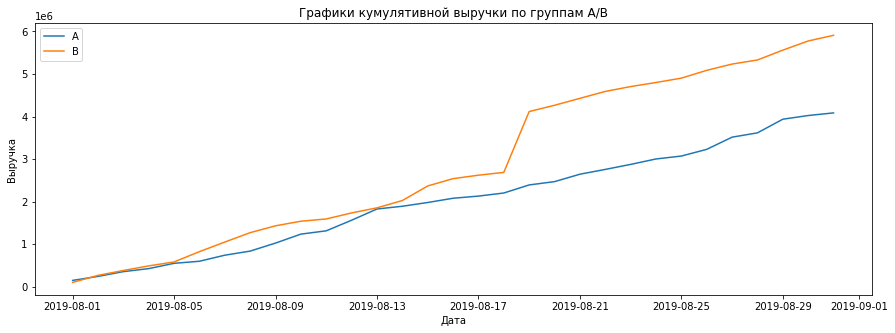

In [14]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15,5))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Графики кумулятивной выручки по группам A/B')
plt.legend()
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. Но группа В показывает стабильно более высокие результаты, чем группа А.

# Строим график кумулятивного среднего чека по группам

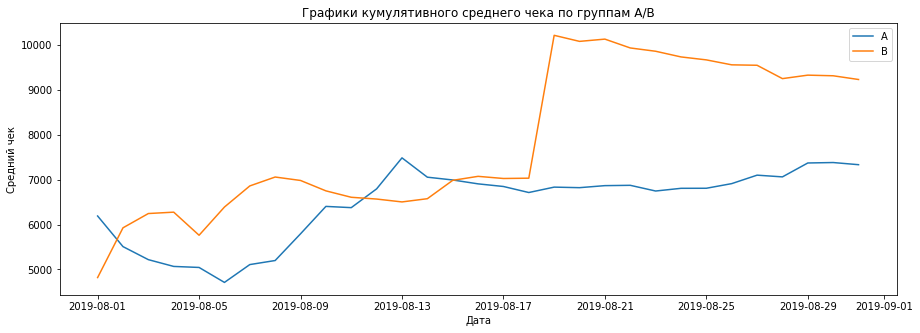

In [15]:
plt.figure(figsize=(15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Графики кумулятивного среднего чека по группам A/B')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.legend()
plt.show()

Средний чек также растет, но для группы В заметен значительный всплеск, возможно это какие-либо аномалии, например, попали попали крупные заказы.

# Строим график относительного изменения кумулятивного среднего чека группы B к группе A

Text(0.5, 0, 'Дата')

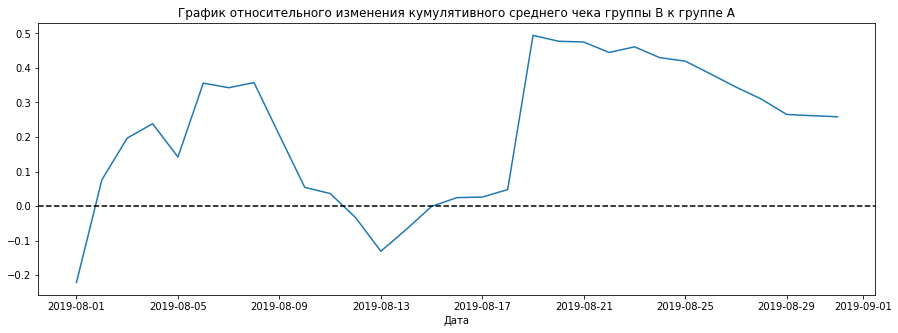

In [16]:
plt.figure(figsize=(15,5))

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')

В нескольких точках график различия между сегментами резко «скачет», предположение выше подтверлилось, где-то есть крупные заказы.

# Строим график кумулятивной конверсии по группам

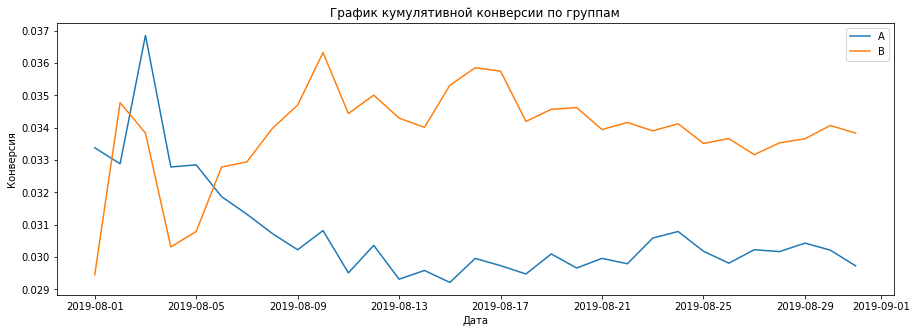

In [17]:
plt.figure(figsize=(15,5))

# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.legend()


Конверсия группы В значительно выше, чем группы А, и показываем стабильно высокий результат.

# Строим график относительного изменения кумулятивной конверсии группы B к группе A

Text(0.5, 0, 'Дата')

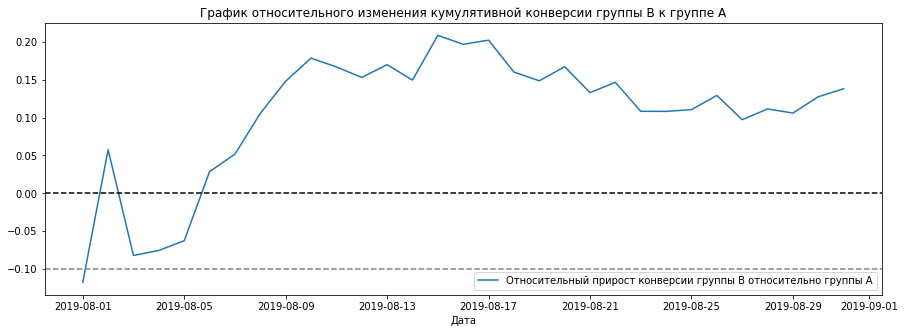

In [18]:
plt.figure(figsize=(15,5))
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')

plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')


Конверсия в группе B стабильно лучше конверсии в группе A.

# Строим точечный график количества заказов по пользователям

In [19]:
# display(orders.head())

       visitorId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


Text(0.5, 1.0, 'Гистограмму распределения числа заказов по пользователям')

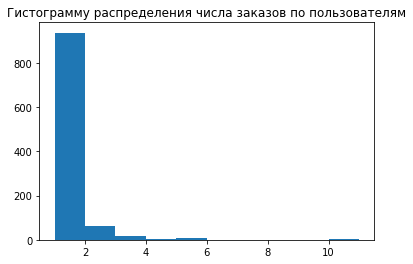

In [20]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['visitorId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

plt.hist(ordersByUsers['orders'])

plt.title('Гистограмму распределения числа заказов по пользователям')

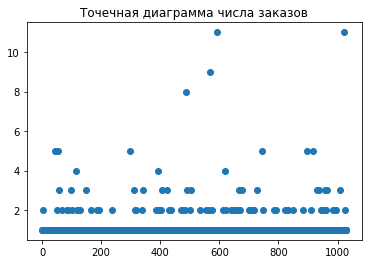

In [21]:
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.title('Точечная диаграмма числа заказов')

plt.scatter(x_values, ordersByUsers['orders']) 

Согласно полученной диаграммы и точечной диаграммы, можно сделать вывод, что пользователи в основном делают менее 2-х заказов.

# Считаем 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [22]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99]))

[1. 2. 4.]


Всего лишь 5% пользователей делают заказ более 2-х раз.

# Строим точечный график стоимостей заказов

Text(0.5, 1.0, 'Гистограмму распределения стоиомости заказов')

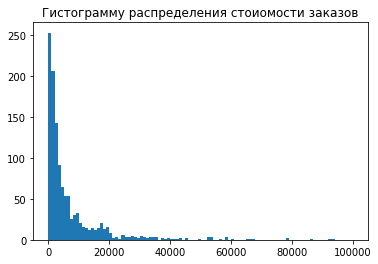

In [23]:

plt.hist(orders['revenue'], range=(0,100000), bins = 100)

plt.title('Гистограмму распределения стоиомости заказов')

Text(0.5, 1.0, 'Точечная диаграмма распределения стоимости заказов')

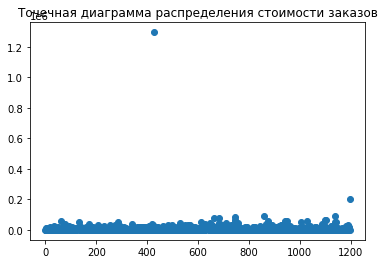

In [24]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечная диаграмма распределения стоимости заказов')

По полученным данным видно, что большая часть пользователей делает покупки на сумму не более 20000 тысяч рублей.

# Считаем 95-й и 99-й перцентили стоимости заказов

In [25]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[18168.  28000.  58233.2]


Можно сделать вывод, что стоиомсть только 5% заказов превышает 28000 рублей.

# Считаем статистическую значимость различий в конверсии между группами по «сырым» данным.

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.
Сформулируем гипотезы. 
Нулевая: различий в конверсии между группами нет. 
Альтернативная: различия в конверсии между группами есть.

In [26]:
display(orders.head())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [27]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))


        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

P-value значительно меньше 0,05 (0,02) - поэтому нулевую гипотезу отвергаем. Анализ "сырых данных" показывает, что в конверсии между группами есть статистически значимые различия. Относительный прирост конверсии группы В к конверсии группы А равен 13,8%.

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [28]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.729
0.259


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Но средний чек группы B значительно выше среднего чека группы A - относитльное различие чека составляет 25,9%.

Выше получены данные о том, что 95-й и 99-й перцентили средних чеков равны 28000 и 58233.2 тысяч рублей. А 95-й и 99-й перцентили числа заказов на одного пользователя равны 2 и 4 заказам на пользователя. 

Примим за аномальных пользователей тех, кто совершил более 2-х заказов, или совершил заказ на сумму свыше 28 000 рублей.

Узнаем, сколько всего аномальных пользователей методом shape().

In [29]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitorId, dtype: int64
(74,)


Всего 74 аномальных пользователя.Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. 

In [30]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [31]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.013
0.173


Результаты по конверсии практически не изменились. Проверим результаты по среднему чеку


In [32]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.738
-0.020


P-value увеличился, но и разница между сегментами сократилась.

## Итоговые выводы

Имеющиеся факты:
-  Анализ "сырых данных" показывает, что в конверсии между группами есть статистически значимые различия. Относительный прирост конверсии группы В к конверсии группы А равен 13,8%.;
- Нет статистически значимого различия по среднему чеку между группами по данным после фильтрации аномалий;
- График различия конверсии между группами сообщает, что конверсия в группе B стабильно лучше конверсии в группе A.
- График различия среднего чека говорит о том, что средний чек группы В значительно выше группы А.
- Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. Продолжать смысла нет, так как мы имеющимся данным мы уже можем зафиксировать победу группы В.